In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 46.8 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 6.8 MB 32.3 MB/s 
     |████████████████████████████████| 596 kB 45.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
"""
import numpy as np
df['split'] = np.random.randn(df.shape[0], 1)

msk = np.random.rand(len(df)) <= 0.7

train = df[msk]
test = df[~msk]
"""

In [ ]:

import tensorflow as tf
import pandas as pd
train = pd.read_csv("/content/gdrive/MyDrive/MTech-project/data/train.csv")
train.head()

,target,tweet
0,1,"Very possible that while rare, antidepressant ..."
1,1,"and too, side effect fears as I have only take..."
2,0,That ll be Madrid throwing a huff over Morata ...
3,1,Can eating grapefruit while on antidepressants...
4,1,"Went from thinking my God, I m a fraud to Holy..."


In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/MTech-project/data/test.csv")
train.head()

,target,tweet
0,1,What a Trump card!! Trying to divert the peopl...
1,0,"Wear a smile, one size fits all. inspire simpl..."
2,0,?? you are respectable ?? pic.twitter.com NiQX...
3,1,Decreased Depression with Transcendental Medit...
4,0,"Harden not your heart, as in the provocation, ..."


In [ ]:
train_feat=train['tweet']
train_lab=train['target']
train1 = pd.DataFrame([train_feat, train_lab]).T
train1.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
#train1['DATA_COLUMN'] = train1['DATA_COLUMN']
train1.head()

,DATA_COLUMN,LABEL_COLUMN
0,What a Trump card!! Trying to divert the peopl...,1
1,"Wear a smile, one size fits all. inspire simpl...",0
2,?? you are respectable ?? pic.twitter.com NiQX...,0
3,Decreased Depression with Transcendental Medit...,1
4,"Harden not your heart, as in the provocation, ...",0


In [ ]:
test_feat=train['tweet']
test_lab=train['target']
test1 = pd.DataFrame([test_feat, test_lab]).T
test1.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
#train1['DATA_COLUMN'] = train1['DATA_COLUMN']
test1.head()

,DATA_COLUMN,LABEL_COLUMN
0,What a Trump card!! Trying to divert the peopl...,1
1,"Wear a smile, one size fits all. inspire simpl...",0
2,?? you are respectable ?? pic.twitter.com NiQX...,0
3,Decreased Depression with Transcendental Medit...,1
4,"Harden not your heart, as in the provocation, ...",0


In [ ]:
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

In [ ]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train1, test1, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_data

<RepeatDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])



In [ ]:
history=model.fit(train_data, epochs=2, validation_data=validation_data)

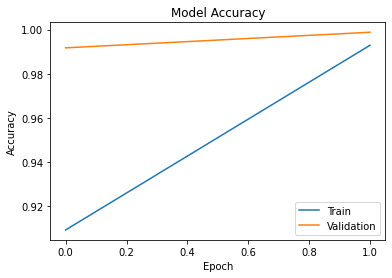

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

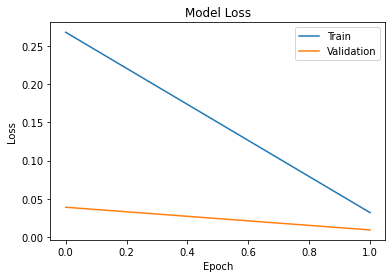

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
pred_sentences = ['Extreme sadness, lack of energy, hopelessness',
                  'Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits',
                  'feeling lonely and leading a boring life']


In [ ]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Non-Depressive','Depressive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])

Extreme sadness, lack of energy, hopelessness : 
 Depressive
Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits : 
 Non-Depressive
feeling lonely and leading a boring life : 
 Depressive


In [ ]:
tf_predictions

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.00351998, 0.99648005],
       [0.99276334, 0.00723667],
       [0.1337498 , 0.86625016]], dtype=float32)>

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.save('/content/gdrive/MyDrive/MTech-project/data/classifier.model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MTech-project/data/classifier.model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/MTech-project/data/classifier.model/assets


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/MyDrive/MTech-project/data/classifier.model')


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (Custom>TFBertMainLaye  multiple                 109482240 
 r)                                                              
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pred_sentences = ['Extreme sadness, lack of energy, hopelessness',
                  'Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits',
                  'feeling lonely and leading a boring life']


In [ ]:
import os
checkpoint_path = "/content/gdrive/MyDrive/MTech-project/data/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
!pwd

/content


In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/MTech-project/data/")

In [ ]:
model.save_weights('path_to_my_weights', save_format='tf')

In [ ]:
model.load_weights('path_to_my_weights')

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________
